# Setup Enviornment

In [1]:
from monai.utils import (
    first, 
    set_determinism, 
    ensure_tuple
)
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotate90d,
    RandShiftIntensityd,
    RandFlipd,
    RandGaussianNoised,
    RandAdjustContrastd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    AddChanneld,
    RandGaussianSharpend,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    OneOf,
    Rand3DElasticd,
    Rand3DElastic,
    RandGridDistortiond,
    RandSpatialCropSamplesd,
    FillHoles,
    LabelFilter,
    LabelToContour
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.metrics import (
    DiceMetric, 
    HausdorffDistanceMetric
)
from monai.losses import (
    DiceLoss, 
    DiceCELoss, 
    DiceFocalLoss,
    FocalLoss
)
from monai.inferers import sliding_window_inference
from monai.data import (
    CacheDataset, 
    DataLoader, 
    Dataset, 
    decollate_batch, 
    ImageReader
)
from monai.data.image_reader import WSIReader
from monai.config import (
    print_config, 
    KeysCollection, 
    PathLike
)
from monai.apps import download_and_extract
import torch
from torchio.transforms import (
    RandomAffine
)
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from numpy import random
from pathlib import Path
import re
from skimage import io
from typing import (
    Optional, 
    Union, 
    Sequence, 
    Callable, 
    Dict, 
    List
)
from monai.data.utils import is_supported_format
from monai. data.image_reader import (
    _copy_compatible_dict, 
    _stack_images
)
from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
from mlflow import log_metric, log_param, log_artifacts, set_experiment, start_run, end_run
import warnings
warnings.filterwarnings('ignore')
from torchviz import make_dot

In [2]:
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from numpy import random
from pathlib import Path
import re
from skimage import io
from typing import (
    Optional, 
    Union, 
    Sequence, 
    Callable, 
    Dict, 
    List
)
#from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
#from mlflow import log_metric, log_param, log_artifacts, set_experiment, start_run, end_run
import warnings

In [3]:
print_config()

MONAI version: 0.8.0
Numpy version: 1.21.4
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.10.0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.2
transformers version: 4.15.0
mlflow version: 1.28.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [4]:
class TIFFReader(ImageReader):
    
    def __init__(self, npz_keys: Optional[KeysCollection] = None, channel_dim: Optional[int] = None, **kwargs):
        super().__init__()
        if npz_keys is not None:
            npz_keys = ensure_tuple(npz_keys)
        self.npz_keys = npz_keys
        self.channel_dim = channel_dim
        self.kwargs = kwargs
    
    def verify_suffix(self, filename: Union[Sequence[PathLike], PathLike]) -> bool:
        """
        Verify whether the specified file or files format is supported by Numpy reader.

        Args:
            filename: file name or a list of file names to read.
                if a list of files, verify all the suffixes.
        """
        suffixes: Sequence[str] = ["tif", "tiff"]
        return is_supported_format(filename, suffixes)

    def read(self, data: Union[Sequence[PathLike], PathLike], **kwargs):
        """
        Read image data from specified file or files, it can read a list of `no-channel` data files
        and stack them together as multi-channels data in `get_data()`.
        Note that the returned object is Numpy array or list of Numpy arrays.

        Args:
            data: file name or a list of file names to read.
            kwargs: additional args for `numpy.load` API except `allow_pickle`, will override `self.kwargs` for existing keys.
                More details about available args:
                https://numpy.org/doc/stable/reference/generated/numpy.load.html

        """
        img_: List[Nifti1Image] = []

        filenames: Sequence[PathLike] = ensure_tuple(data)
        kwargs_ = self.kwargs.copy()
        kwargs_.update(kwargs)
        for name in filenames:
            img = io.imread(name, **kwargs_)
            img = img.astype('float32')
            if len(img.shape)==4:
                img = np.swapaxes(img,0,1)
                img = np.swapaxes(img,1,3)
            img_.append(img)
        return img_ if len(img_) > 1 else img_[0]
    
    def get_data(self, img):
        """
        Extract data array and meta data from loaded image and return them.
        This function returns two objects, first is numpy array of image data, second is dict of meta data.
        It constructs `affine`, `original_affine`, and `spatial_shape` and stores them in meta dict.
        When loading a list of files, they are stacked together at a new dimension as the first dimension,
        and the meta data of the first image is used to represent the output meta data.

        Args:
            img: a Numpy array loaded from a file or a list of Numpy arrays.

        """
        img_array: List[np.ndarray] = []
        compatible_meta: Dict = {}
        if isinstance(img, np.ndarray):
            img = (img,)

        for i in ensure_tuple(img):
            header = {"affine":np.eye(5),
                     "labels": {"0": "background",
                                "1": "vessels",
                                "2": "neurons",}
                     }
            if isinstance(i, np.ndarray):
                # if `channel_dim` is None, can not detect the channel dim, use all the dims as spatial_shape
                spatial_shape = np.asarray(i.shape)
                if isinstance(self.channel_dim, int):
                    spatial_shape = np.delete(spatial_shape, self.channel_dim)
                header["spatial_shape"] = spatial_shape
            img_array.append(i)
            header["original_channel_dim"] = self.channel_dim if isinstance(self.channel_dim, int) else "no_channel"
            _copy_compatible_dict(header, compatible_meta)

        return _stack_images(img_array, compatible_meta), compatible_meta

# Hyperparameters

In [5]:
parameter_file = 'hyperparameter_pickle_files/parameters436.pickle'

In [6]:
experiment = re.sub('.pickle',
                    '',
                    re.sub('hyperparameter_pickle_files/parameters',
                           '',
                           parameter_file
                          )
                   )
set_experiment("TBI_UNet_adam_optimizer_demo")

Traceback (most recent call last):
  File "/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 270, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 394, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 1049, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/mlflow/store/tracking/file_store.py", line 1042, in _read_helper
    result = read_yaml(root, file_name)
  File "/lustre06/project/6023374/rozakmat/monai3.8/lib/python3.8/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    r

<Experiment: artifact_location='file:///lustre06/project/6061907/rozakmat/TBI_monai_UNET/mlruns/1', experiment_id='1', lifecycle_stage='active', name='TBI_UNet_adam_optimizer_demo', tags={}>

In [7]:
experiment

'436'

In [17]:
with open(parameter_file, 'rb') as handle:
    params = pickle.load(handle)

In [18]:
for i in params.keys():
    log_param(i,params[i])

# setup directory to save enviornment

In [19]:
directory = re.sub('.pickle',
                   '',
                   re.sub('hyperparameter_pickle_files/parameters',
                          'training_models/',
                           parameter_file
                         )
                  )
try:
    os.mkdir(directory)
except OSError as error:
    print(error) 
#log_artifacts(directory)
print(directory)


[Errno 17] File exists: 'training_models/436'
training_models/436


In [20]:
directory

'training_models/436'

# get train and validate data

In [21]:
#make list of data dictionaries
train_images_path = Path('../TBI/GT_filtered+raw/') #raw path images
train_images_paths = list(train_images_path.glob('*.tif'))#get images
train_images = sorted([x.as_posix() for x in train_images_paths])#sort
train_labels_path = Path('../TBI/GT_filtered+raw/')#labels path
train_labels = list(train_labels_path.glob('*sub1.tiff'))#get label images
train_labels = sorted([x.as_posix() for x in train_labels])#sort
#combine images and labels into monai dictionary format
data_dicts = [
    {"image":image_name, "label":label_name}
    for image_name, label_name in zip(train_images,train_labels)
]

In [22]:
mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
images = sorted([y.name for y in train_images_paths])#sort
#get mouse id corresponding to each image i have labels for
mouse_ids_with_raw_tiff = []
for i in mouse_ids:
    for j in images:
        if len(list(i.glob(j))) !=0:
            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
#flatten the list and sort
mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)

In [23]:
#shuffle mouse ids for a 15/4/6 split train/val/test by mouse id
mouse_ids_present = [i.parent.name for i in mouse_ids_with_raw_tiff_flat]
mouse_ids_present = sorted(list(np.unique(mouse_ids_present)))
np.random.seed(643)
np.random.shuffle(mouse_ids_present)
mouse_ids_present
train = mouse_ids_present[:15]
#log_param('train_set',' '.join(train))
val = mouse_ids_present[15:-6]
#log_param('val_set',' '.join(val))
test = mouse_ids_present[-6:]

In [24]:
len(train)

15

In [25]:
train_files = []
val_files = []
test_files = []
for i in train:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    train_files.append(k)
for i in val:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    val_files.append(k)
for i in test:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    test_files.append(k)

# Set deterministic training for reproducability

In [26]:
set_determinism(seed=12)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [27]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader = TIFFReader(channel_dim = 0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        #random cropping
        RandSpatialCropSamplesd(
            keys=['image','label'],
            num_samples = 6,#params['N_crops'],
            roi_size = params['crop_size'],
            random_size = False
        ),
        #Deformation_transforms
        OneOf(transforms=[Rand3DElasticd(keys = ["image","label"],
                                        sigma_range = params['Rand3DElasticd_sigma_range'],
                                        magnitude_range = params['Rand3DElasticd_magnitude_range'],
                                        prob = params["deformation_transforms_prob"],
                                        mode = ["bilinear","nearest"]),
                          RandGridDistortiond(keys = ["image","label"],
                                             num_cells = params['RandGridDistortiond_num_cells'],
                                             prob = params["deformation_transforms_prob"],
                                             distort_limit = params['RandGridDistortiond_distort_limit'],
                                             mode = ["bilinear","nearest"]
                                             )
                         ]
             ),
        #Intensity_Transforms
        OneOf(transforms = [RandShiftIntensityd(keys = ["image"],
                                                offsets = params['RandShiftIntensityd_offsets'],
                                                prob = params["intensity_transform_probability"]),
                            RandAdjustContrastd(keys = ["image"],
                                                prob = params["intensity_transform_probability"],
                                                gamma = params['RandAdjustContrastd_gamma']),
                            RandHistogramShiftd(keys = ["image"],
                                                prob = params["intensity_transform_probability"],
                                                num_control_points = params['RandHistogramShiftd_num_control_points'])
                           ]
             ),
        #Gaussian_Transforms
        OneOf(transforms = [RandGaussianSharpend(keys = ["image"],
                                                 prob = params["gaussian_transform_probability"]),
                            RandGaussianSmoothd(keys = ["image"],
                                                prob = params["gaussian_transform_probability"]),
                            RandGaussianNoised(keys = ["image"],
                                               prob = params["gaussian_transform_probability"],
                                               mean = params['RandGaussianNoised_mean'],
                                               std = params['RandGaussianNoised_std'])
                           ]
             ),
        #rottion+flip_transforms
        RandRotate90d(
            keys = ["image", "label"],
            prob = params['rotation_flip_transforms_probability'],
            max_k = 3,
            spatial_axes=(0,1)
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [0],
            prob = params['rotation_flip_transforms_probability'],
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [1],
            prob = params['rotation_flip_transforms_probability'],
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [2],
            prob = params['rotation_flip_transforms_probability'],
        ),
        #random affine
        RandomAffine(
            include=["image", "label"], 
            p=params["RandomAffine_probability"], 
            degrees=params["RandomAffine_degrees"], 
            scales=params["RandomAffine_scales"],
            translation=params["RandomAffine_translation"],
            center='image'
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],reader = TIFFReader(channel_dim = 0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# Check transforms in DataLoader

In [31]:
io.imread(val_files[0]['label']).shape

(96, 1, 512, 512)

In [33]:
import monai
monai.__version__

'0.8.0'

image shape: torch.Size([2, 507, 507, 252]), label shape: torch.Size([1, 507, 507, 252])


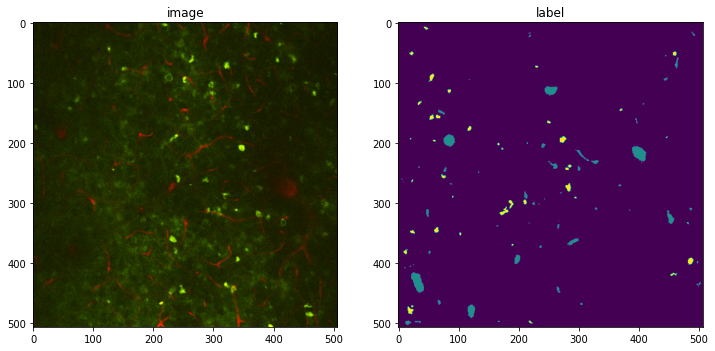

In [29]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0], check_data["label"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [ :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.transpose(image[:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.transpose(label[:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
plt.imshow(img3)
plt.show()

#check_ds = Dataset(data=val_files, transform=val_transforms_deform)
#check_loader = DataLoader(check_ds, batch_size=1)
#check_data = first(check_loader)
#image2, label2 = (check_data["image"][0], check_data["label"][0])
#print(f"image shape: {image2.shape}, label shape: {label2.shape}")
## plot the slice [ :, 80]
#plt.figure("check", (12, 6))
#plt.subplot(1, 2, 1)
#plt.title("image")
#img2 = torch.swapaxes(image2[:,:, :, 80],0,2)
#img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
#plt.imshow(img2, cmap="gray")
#plt.subplot(1, 2, 2)
#plt.title("label")
#img3 = torch.swapaxes(label2[:,:, :, 80],0,2)
#img3 = img3.cpu().detach().numpy()
#plt.imshow(img3)
#plt.show()
#
#post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])
#
#label = post_label(label)
#label2 = post_label(label2)

In [22]:
#label_filter = Compose([EnsureType(), LabelFilter(applied_labels=(1))])
#
#dice_metric = DiceMetric(include_background=False, reduction="mean")
#label = label_filter(label)
#label2 = label_filter(label2)
#contour = LabelToContour()(label_filter(label))
##print(contour.shape)
#contour2 = LabelToContour()(label_filter(label2))
#dice_metric(y_pred=contour, y=contour2)
#metric = dice_metric.aggregate().item()
#dice_metric.reset()
#print(metric)
#print("boundary difference",torch.sum(contour2.ne(contour).long()))
#print("total boundary size",torch.sum(contour2.ne(contour).long())/torch.sum(contour)*100)
#label.shape

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [23]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [24]:
#!ps aux | grep python

In [25]:
#!kill 58652316

In [26]:
train_ds = CacheDataset(
    data = train_files, 
    transform = train_transforms,
    cache_rate = 1.0, 
    num_workers = 4
)
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(
    train_ds, 
    batch_size=1,#params["batch_size"], 
    shuffle=True, 
    num_workers=4
)

val_ds = CacheDataset(
    data = val_files, 
    transform = val_transforms, 
    cache_rate = 1.0, 
    num_workers = 4
)
val_loader = DataLoader(
    val_ds, 
    batch_size = 1, 
    num_workers = 4
)

#val_ds_deform = CacheDataset(
#    data=val_files, transform=val_transforms_deform, cache_rate=1.0, num_workers=4)
#val_loader_deform = DataLoader(val_ds_deform, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 6/6 [01:00<00:00, 10.04s/it]


# Create Model, Loss, Optimizer

In [28]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
#device = torch.device("cuda:0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    img_size = (128,128,128),
    feature_size = 16,
    hidden_size = 768,
    mlp_dim = 3072,
    pos_embed = "perceptron",
    res_block=True,
    norm_name="instance",
    dropout_rate=params["dropout"]
)
model = torch.nn.DataParallel(model)
model.to(device)
#model.load_state_dict(torch.load(
#    os.path.join(directory, "best_metric_model.pth")))
loss_function = params['loss_function']
loss_focal = FocalLoss(include_background=False,to_onehot_y=True)

optimizer = params['optimizer'](params = model.parameters(), 
                                lr = 1e-5)#params['learning_rate'])
dice_metric = DiceMetric(
    include_background=False,
    reduction="mean"
)
#hausdorf_distance_metric = HausdorffDistanceMetric(include_background=False,
#                                                   distance_metric='euclidean')
dice_metric_deform = DiceMetric(
    include_background = False,
    reduction = "mean"
)
dice_metric_deform_boundary_difference = DiceMetric(
    include_background = False,
    reduction = "mean"
)
dice_metric_predicted_deform_boundary_difference = DiceMetric(
    include_background = False,
    reduction = "mean"
)
dice_metric_boundary_difference_detection = DiceMetric(
    include_background = False,
    reduction = "mean"
)
label_filter = Compose(
    [EnsureType(),
     LabelFilter(applied_labels = (1))
    ]
)
deform = Rand3DElastic(
    sigma_range = (1,2),
    magnitude_range = (3,4),
    prob = 1
)

In [33]:
batch = next(iter(train_loader))
yhat = model(batch['image'])

In [35]:
make_dot(yhat,params=dict(list(model.named_parameters()))).render("UNETR_torchviz",format="png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.880952 to fit


'UNETR_torchviz.png'

# Execute a typical PyTorch training process

In [ ]:
random.seed(12)
max_epochs = params["max_epochs"]
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
#hausdorf_distance_values = []
metric_values_deform = []
metric_values_deform_boundary_difference = []
metric_values_predicted_deform_boundary_difference = []
metric_values_boundary_difference_detection = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,to_onehot=3)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])
for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_focal_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        ############################################################################################
        optimizer.zero_grad()
        outputs_pred = [post_pred(i) for i in decollate_batch(outputs)]
        outputs_pred_t = torch.stack(outputs_pred)
        inputs_deform = [i for i in decollate_batch(inputs)]
        seed = random.randint(0,10000000)
        #deform raw image
        deform.set_random_state(seed = seed)
        deform_inputs = [deform(i,mode='bilinear') for i in inputs_deform]
        deform_inputs = torch.stack(deform_inputs)
        #deform validation output
        deform.set_random_state(seed = seed)
        deform_outputs_gt = [AsDiscrete(argmax=True)(deform(i,mode='nearest')) for i in outputs_pred]
        deform_outputs_gt = torch.stack(deform_outputs_gt)
        outputs_deform_and_og = model(torch.cat((inputs,deform_inputs),dim=0))
        loss_focal = loss_function(
            outputs_deform_and_og, 
            torch.cat((torch.argmax(outputs,dim=1,keepdims=True),deform_outputs_gt),dim=0)
        )
        loss_focal.backward()
        ############################################################################################
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_focal_loss /= step
    epoch_loss_values.append(epoch_loss)
    #log_metric('epoch_loss',epoch_loss, step = epoch)
    #log_metric('epoch_focal_loss',epoch_focal_loss, step = epoch)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                seed = random.randint(0,10000000)
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                #val_inputs_deform, val_labels_deform = (
                #    val_data_deform["image"].to(device),
                #    val_data_deform["label"].to(device),
                #)
                roi_size = (128, 128, 128)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, 
                    roi_size, 
                    sw_batch_size, 
                    model
                )
                #get prediciton output
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                filled  = [FillHoles(connectivity=2)(i) for i in val_outputs]
                #deform raw image
                deform.set_random_state(seed = seed)
                deform_val_inputs = torch.unsqueeze(deform(torch.squeeze(val_inputs),mode='bilinear'),axis=0)
                #deform validation output
                deform.set_random_state(seed = seed)
                deform_val_outputs_gt = deform(filled[0],mode='nearest')
                #predict on deformed raw image
                deform_val_outputs =sliding_window_inference(
                    deform_val_inputs, 
                    roi_size, 
                    sw_batch_size, 
                    model
                )   
                # get predicted outputs
                val_outputs_deform = [post_pred(i) for i in decollate_batch(deform_val_outputs)]
                #fill holes in prediction
                filled_deform  = [FillHoles(connectivity=2)(i) for i in val_outputs_deform]
                #generated boundaries from predictions
                filled_vessels_boundary = [LabelToContour()(label_filter(i)) for i in filled]
                filled_vessels_boundary_deform = [LabelToContour()(label_filter(i)) for i in filled_deform]
                #get labelled data
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                #print(val_labels.shape)
                val_labels_deform = [deform_val_outputs_gt]
                #get validation boundaries
                val_labels_boundary = [LabelToContour()(i) for i in val_labels]
                val_outputs_boundary_deform = [LabelToContour()(i) for i in val_labels_deform]
                # compute metric for current iteration
                #dice metric for ground truth and prediction
                dice_metric(
                    y_pred = filled,
                    y = val_labels
                )
                #hausdorf_distance_metric(y_pred=filled, 
                #                         y=val_labels)
                #dice metric for deformed output, and prediction on deformed raw image
                dice_metric_deform(
                    y_pred = filled_deform,
                    y = val_outputs_deform
                )
                #dice metric for boundary of ground truth and deformed ground truth
                #measures how much the boundary was deformed
                dice_metric_deform_boundary_difference(
                    y_pred = val_outputs_boundary_deform,
                    y = filled_vessels_boundary
                )
                
                dice_metric_predicted_deform_boundary_difference(
                    y_pred=val_outputs_boundary_deform[0],
                    y=filled_vessels_boundary_deform[0]
                )
                #dice metric for boundary difference detection
                dice_metric_boundary_difference_detection(
                    y_pred = filled_vessels_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1],
                    y = val_outputs_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]
                )

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            #log_metric(
            #    'dice',
            #    metric,
            #    step = epoch
            #)
            ##hausdorf_distance = hausdorf_distance_metric.aggregate().item()
            ##aggregate the dice score for the prediction fo the deformed raw image againsed the deformed prediction
            metric_deform = dice_metric_deform.aggregate().item()
            #log_metric(
            #    'dice_deformed_validation',
            #    metric_deform,
            #    step = epoch
            #)
            metric_deform_boundary_difference = dice_metric_deform_boundary_difference.aggregate().item()
            #log_metric(
            #    'ground_truths_boundary_dice',
            #    metric_deform_boundary_difference,
            #    step = epoch
            #)
            metric_predicted_deform_boundary_difference = dice_metric_predicted_deform_boundary_difference.aggregate().item()
            #log_metric(
            #    'predicted_boundary_dice',
            #    metric_predicted_deform_boundary_difference,
            #    step = epoch
            #)
            metric_boundary_difference_detection = dice_metric_boundary_difference_detection.aggregate().item()
            #log_metric(
            #    'dice_deformed_boundary_ground_truth_to_prediction',
            #    metric_boundary_difference_detection,
            #    step = epoch
            #)
            # reset the status for next validation round
            dice_metric.reset()
            #hausdorf_distance_metric.reset()
            dice_metric_deform.reset()
            dice_metric_deform_boundary_difference.reset()
            #dice_metric_predicted_deform_boundary_difference.reset()
            dice_metric_boundary_difference_detection.reset()

            metric_values.append(
                metric
            )
            #hausdorf_distance_values.append(
            #    hausdorf_distance
            #)
            metric_values_deform.append(
                metric_deform
            )
            metric_values_deform_boundary_difference.append(
                metric_deform_boundary_difference
            )
            metric_values_predicted_deform_boundary_difference.append(
                metric_predicted_deform_boundary_difference
            )
            metric_values_boundary_difference_detection.append(
                metric_boundary_difference_detection
            )
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                #torch.save(model.state_dict(), os.path.join(
                #    directory, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                #f"\ncurrent mean hausdorf distance: {hausdorf_distance:.4f}"
                f"\ncurrent mean dice of deformed mask to predicted deformed image: {metric_deform:.4f}"
                f"\ncurrent mean dice of boundary of ground truth, and  boundary of deformed ground truth: {metric_deform_boundary_difference:.5f}"
                #f"\ncurrent mean dice of preficted boundary, and predicted deformed boundary: {metric_predicted_deform_boundary_difference:.5f}"
                f"\ncurrent mean dice of the boundary difference due to deformation: {metric_boundary_difference_detection:.5f}"
                #f"\nratio of dice of boundary deformation to ground truth on prediction and ground truth:{metric_predicted_deform_boundary_difference/metric_deform_boundary_difference}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|                                                                                                      | 0/430 [00:00<?, ?it/s]

----------
epoch 1/430
1/27, train_loss: 1.2045
2/27, train_loss: 1.2625
3/27, train_loss: 1.2656
4/27, train_loss: 1.2688
5/27, train_loss: 1.2153
6/27, train_loss: 1.2005
7/27, train_loss: 1.2394
8/27, train_loss: 1.2133
9/27, train_loss: 1.2775
10/27, train_loss: 1.2635
11/27, train_loss: 1.2560
12/27, train_loss: 1.2401
13/27, train_loss: 1.2150
14/27, train_loss: 1.2424
15/27, train_loss: 1.2604
16/27, train_loss: 1.2509
17/27, train_loss: 1.2491
18/27, train_loss: 1.2371
19/27, train_loss: 1.2464
20/27, train_loss: 1.2395
21/27, train_loss: 1.2138
22/27, train_loss: 1.2706
23/27, train_loss: 1.2833
24/27, train_loss: 1.1905
25/27, train_loss: 1.2155
26/27, train_loss: 1.2132


  0%|▏                                                                                         | 1/430 [01:40<11:57:01, 100.28s/it]

27/27, train_loss: 1.2508
epoch 1 average loss: 1.2402
----------
epoch 2/430
1/27, train_loss: 1.2425
2/27, train_loss: 1.2414
3/27, train_loss: 1.2563
4/27, train_loss: 1.2811
5/27, train_loss: 1.2246
6/27, train_loss: 1.2102
7/27, train_loss: 1.2480
8/27, train_loss: 1.2096
9/27, train_loss: 1.2646
10/27, train_loss: 1.2016
11/27, train_loss: 1.1892
12/27, train_loss: 1.2417
13/27, train_loss: 1.1703
14/27, train_loss: 1.1824
15/27, train_loss: 1.1864
16/27, train_loss: 1.2806
17/27, train_loss: 1.2179
18/27, train_loss: 1.1995
19/27, train_loss: 1.2158
20/27, train_loss: 1.2563
21/27, train_loss: 1.2462
22/27, train_loss: 1.2526
23/27, train_loss: 1.2494
24/27, train_loss: 1.2113
25/27, train_loss: 1.2592
26/27, train_loss: 1.2069
27/27, train_loss: 1.2643
epoch 2 average loss: 1.2300


In [ ]:
outputs_pred = [post_pred(i) for i in decollate_batch(outputs)]
inputs_deform = [i for i in decollate_batch(inputs)]
seed = random.randint(0,10000000)
#deform raw image
deform.set_random_state(seed = seed)
deform_inputs = [deform(i,mode='bilinear') for i in inputs_deform]
deform_inputs = torch.stack(deform_inputs)
#deform validation output
deform.set_random_state(seed = seed)
deform_outputs_gt = [AsDiscrete(argmax=True)(deform(i,mode='nearest')) for i in outputs_pred]
deform_outputs_gt = torch.stack(deform_outputs_gt)

In [ ]:
inputs.shape

In [ ]:
deform_inputs.shape

In [ ]:
torch.cat((inputs,deform_inputs),dim=0).shape

In [ ]:
torch.cat((torch.argmax(outputs,dim=1,keepdims=True),deform_outputs_gt),dim=0).shape

In [ ]:
torch.argmax(outputs,dim=1,keepdims=True).shape

In [ ]:
labels.shape

In [ ]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.transpose(val_outputs_boundary_deform[0][:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2[:,:,1], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.transpose(val_labels_boundary[0][:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
plt.imshow(img3[:,:,1], cmap='gray')
plt.show()

In [ ]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.transpose(filled_vessels_boundary_deform[0][:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2[:,:,1], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.transpose(filled_vessels_boundary[0][:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
plt.imshow(img3[:,:,1], cmap='gray')
plt.show()

In [ ]:
y_pred = filled_vessels_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]
y = val_outputs_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]

In [ ]:
#y_pred = filled_vessels_boundary_deform[0].ne(val_labels_boundary[0]).int()[1]
#y = val_outputs_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]

In [ ]:
y.shape

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)
record_metric("best_epoch",best_metric_epoch)

In [ ]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = y_pred[:,:, 80]
img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2[:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = y[:, :, 80]
img3 = img3.cpu().detach().numpy()
plt.imshow(img3[:,:], cmap='gray')
plt.show()

# Save metrics

In [ ]:
df = pd.DataFrame()
df['Epoch_Average_Loss'] = epoch_loss_values
df.to_csv(directory + '/metrics_loss.csv')
df = pd.DataFrame()
df['Val_Mean_Dice'] = metric_values
df['boundary_detection_dice'] = metric_values_boundary_difference_detection
df['boundary_difference_dice'] = metric_values_deform_boundary_difference
#df.to_csv(directory + '/metrics_validation.csv')

# Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(directory +'ipynb_trial_Val_Loss+Dice.png')
plt.show()

# Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(directory, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

# Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(directory, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)

In [ ]:
random.seed(12)
max_epochs = params["max_epochs"]
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
#hausdorf_distance_values = []
metric_values_deform = []
metric_values_deform_boundary_difference = []
metric_values_predicted_deform_boundary_difference = []
metric_values_boundary_difference_detection = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,to_onehot=3)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=3)])
for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    log_metric('epoch_loss',epoch_loss, step = epoch)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                seed = random.randint(0,10000000)
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (128, 128, 128)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, 
                    roi_size, 
                    sw_batch_size, 
                    model
                )
                #get prediciton output
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                #deform raw image
                deform.set_random_state(seed = seed)
                deform_val_inputs = torch.unsqueeze(deform(torch.squeeze(val_inputs),mode='bilinear'),axis=0)
                #deform validation output
                deform.set_random_state(seed = seed)
                deform_val_outputs_gt = deform(val_outputs[0],mode='nearest')
                #predict on deformed raw image
                deform_val_outputs =sliding_window_inference(
                    deform_val_inputs, 
                    roi_size, 
                    sw_batch_size, 
                    model
                )   
                # get predicted outputs
                val_outputs_deform = [post_pred(i) for i in decollate_batch(deform_val_outputs)]
                #fill holes in prediction
                filled  = [FillHoles(applied_labels=[1],connectivity=2)(i) for i in val_outputs]
                filled_deform  = [FillHoles(applied_labels=[1],connectivity=2)(i) for i in val_outputs_deform]
                #generated boundaries from predictions
                filled_vessels_boundary = [LabelToContour()(label_filter(i)) for i in filled]
                filled_vessels_boundary_deform = [LabelToContour()(label_filter(i)) for i in filled_deform]
                #get labelled data
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                #print(val_labels.shape)
                val_labels_deform = [deform_val_outputs_gt]
                #get validation boundaries
                val_labels_boundary = [LabelToContour()(i) for i in val_labels]
                val_outputs_boundary_deform = [LabelToContour()(i) for i in val_labels_deform]
                # compute metric for current iteration
                #dice metric for ground truth and prediction
                dice_metric(
                    y_pred = filled,
                    y = val_labels
                )
                #hausdorf_distance_metric(y_pred=filled, 
                #                         y=val_labels)
                #dice metric for deformed output, and prediction on deformed raw image
                dice_metric_deform(
                    y_pred = filled_deform,
                    y = val_outputs_deform
                )
                #dice metric for boundary of ground truth and deformed ground truth
                #measures how much the boundary was deformed
                dice_metric_deform_boundary_difference(
                    y_pred = val_outputs_boundary_deform,
                    y = filled_vessels_boundary
                )
                #dice metric for boundary difference detection
                dice_metric_boundary_difference_detection(
                    y_pred=val_outputs_boundary_deform[0],
                    y=filled_vessels_boundary_deform[0]
                )

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            log_metric(
                'dice',
                metric,
                step = epoch
            )
            #hausdorf_distance = hausdorf_distance_metric.aggregate().item()
            #aggregate the dice score for the prediction fo the deformed raw image againsed the deformed prediction
            metric_deform = dice_metric_deform.aggregate().item()
            log_metric(
                'dice_deformed_validation',
                metric_deform,
                step = epoch
            )
            metric_deform_boundary_difference = dice_metric_deform_boundary_difference.aggregate().item()
            log_metric(
                'ground_truths_boundary_dice',
                metric_deform_boundary_difference,
                step = epoch
            )
            metric_boundary_difference_detection = dice_metric_boundary_difference_detection.aggregate().item()
            log_metric(
                'dice_deformed_boundary_ground_truth_to_prediction',
                metric_boundary_difference_detection,
                step = epoch
            )
            # reset the status for next validation round
            dice_metric.reset()
            dice_metric_deform.reset()
            dice_metric_deform_boundary_difference.reset()
            dice_metric_boundary_difference_detection.reset()

            metric_values.append(
                metric
            )
            #hausdorf_distance_values.append(
            #    hausdorf_distance
            #)
            metric_values_deform.append(
                metric_deform
            )
            metric_values_deform_boundary_difference.append(
                metric_deform_boundary_difference
            )
            metric_values_boundary_difference_detection.append(
                metric_boundary_difference_detection
            )
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    directory, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\ncurrent mean dice of deformed mask to predicted deformed image: {metric_deform:.4f}"
                f"\ncurrent mean dice of boundary of ground truth, and  boundary of deformed ground truth: {metric_deform_boundary_difference:.5f}"
                f"\ncurrent mean dice of the boundary difference due to deformation: {metric_boundary_difference_detection:.5f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )